# ML/DL for Everyone

### 출처

- 모두를 위한 딥러닝 시즌2
- 링크: [모두를 위한 딥러닝 시즌2](https://www.youtube.com/watch?v=7eldOrjQVi0&list=PLQ28Nx3M4Jrguyuwg4xe9d9t2XE639e5C)

<br/>

<hr/>

## Dropout

<br/>

<hr/>

### Overfitting이란?

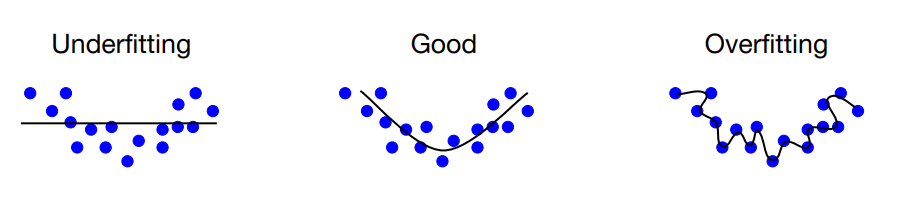

- 제일 왼쪽은 linear fitting 모델, 가운데는 곡선으로 fitting한 모델, 오른쪽은 고차원(highdimensional) 모델이다.
- 과소적합(Underfitting)은 모델이 학습 오류를 줄이지 못하는 상황을 의미한다.
- 과적합(Overfitting)은 너무 과하게 학습된 것을 뜻한다.

<br/><br/>

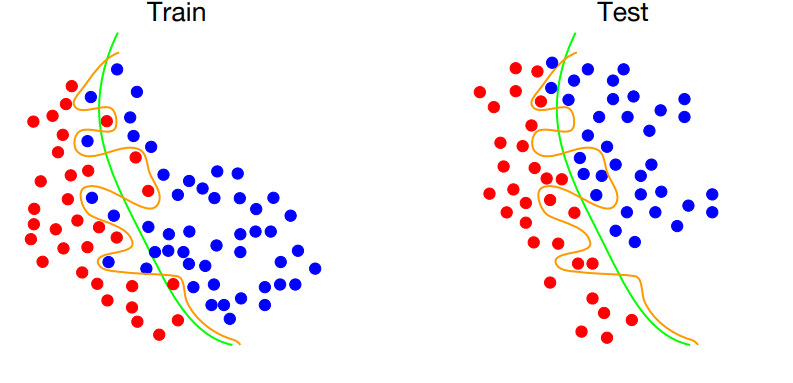

- 왼쪽 그림은 train에 대해서는 분류 정확도(acurracy) 100%를 달성했다는 뜻이다.
- 실제 학습한 것을 바탕으로 테스트를 진행하면 성능이 그리 좋지 않다는 것을 알 수 있다. 오분류가 일어난다.
- train-set과 test-set이 똑같지 않기 때문에 일어나는 현상이다. 오히려 Overftting이 error 발생율을 증가시킬 수 있다.
- 오히려 적당한 학습으로 곡선으로 그려진 분류가 더 정확한 것을 확인할 수 있다.


<br/><br/>

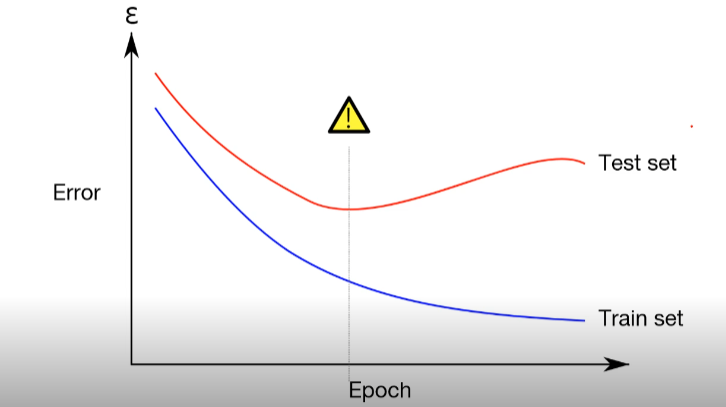

- 위 그림은 Epoch에 따른 Error 발생율을 표현한 그래프이다.
- Epoch가 클 수록 Overfitting될 확률이 올라간다.

<br/><br/>

<hr/>

### Solutions for overfitting

<br/>

과적합(overfitting)을 해결할 수 있는 방법은 다음과 같다.
- training 데이터를 늘린다.
- 요소를 구별하는 특징(feature)의 개수를 줄인다.
- Regularization term을 추가한다.
- **Dropout을 사용**한다.

이 중에 **Dropout**에 대해 알아보자.

<br/>

### Dropout

<br/>

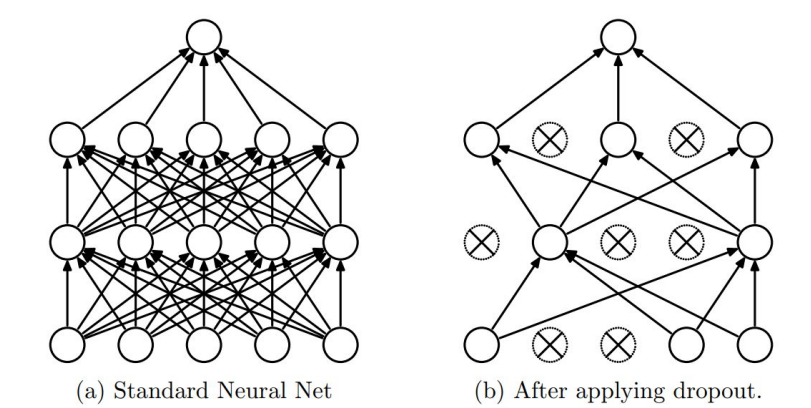

오른쪽의 그림이 Dropout이 적용된 모습이다. **Dropout의 설명**은 아래와 같다.

- 학습을 진행하면서 각 Layer에 존재하는 노드(뉴런)들을 무작위 혹은 설정된 비율에 따라서 on-off를 반복하는 것을 말한다.
- 입력이 있을 때, 켜진 노드의 가중치(weight)만을 이용해 전파되고, 역전파로 피드백을 받는다.
- 다음 전파 때 다시 on-off될 노드를 선택해 다시 전파와 역전파 과정이 반복된다.

<br/><br/>

<hr/>

### Code: MNIST nn Dropout

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()

# 여기서 'p'의 의미는 확률을 뜻한다.
# 전체 노드 중 몇 % 정도를 사용하지 않을지 설정하는 것이다.
# drop_prob로 설정된 값이 0.3이고 첫번째 Layer의 전체 노드 수가 784개라고 했을 때 약 548개정도만 사용하게 될 것이다.
dropout = torch.nn.Dropout(p=drop_prob)

# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [4]:
# model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br/>

- evaluation 모드와 train 모드에 항상 주의해 사용해야한다.
- 학습할 때는 train()을 사용

```python
model.train()
```

- test를 진행할 때는 전체 노드를 사용하기 때문에 eval()을 사용

```python
model.eval()
```

In [5]:
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.311182290
Epoch: 0002 cost = 0.143698409
Epoch: 0003 cost = 0.114890762
Epoch: 0004 cost = 0.092205748
Epoch: 0005 cost = 0.083808832
Epoch: 0006 cost = 0.075272135
Epoch: 0007 cost = 0.067574799
Epoch: 0008 cost = 0.064532466
Epoch: 0009 cost = 0.055667430
Epoch: 0010 cost = 0.055805542
Epoch: 0011 cost = 0.051862556
Epoch: 0012 cost = 0.049264625
Epoch: 0013 cost = 0.048282679
Epoch: 0014 cost = 0.044426568
Epoch: 0015 cost = 0.046410222
Learning finished


In [6]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9799999594688416
Label:  8
Prediction:  8


C:\Users\ghpmc\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\ghpmc\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
